In [25]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam




In [2]:
# Paths
TRAIN_DIR = "organized_dataset/train"  # Path to your organized dataset
VALIDATION_SPLIT = 0.25  # Split 20% of training data for validation
IMAGE_SIZE = (224, 224)  # Input size for ResNet50
BATCH_SIZE = 32  # Adjust based on your hardware
NUM_CLASSES = len(os.listdir(TRAIN_DIR))  # Count subdirectories (one per landmark)
EPOCHS = 40  # Adjust based on the size of your dataset
LEARNING_RATE = 1e-5


In [3]:
# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=VALIDATION_SPLIT
)


# Training Generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
)

# Validation Generator
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Print class indices for reference
print("Class indices:", train_generator.class_indices)


Found 2494 images belonging to 14 classes.
Found 822 images belonging to 14 classes.
Class indices: {'10618': 0, '126637': 1, '151942': 2, '171772': 3, '176528': 4, '177870': 5, '192931': 6, '20409': 7, '41808': 8, '45428': 9, '62074': 10, '62798': 11, '83144': 12, '84689': 13}


In [4]:
# Training Class Counts
train_class_counts = np.bincount(train_generator.classes)
print("Training class counts:")
for class_label, class_index in train_generator.class_indices.items():
    print(f"{class_label}: {train_class_counts[class_index]}")

# Validation Class Counts
val_class_counts = np.bincount(validation_generator.classes)
print("\nValidation class counts:")
for class_label, class_index in validation_generator.class_indices.items():
    print(f"{class_label}: {val_class_counts[class_index]}")

# Total Number of Images in Training and Validation
print(f"\nTotal training images: {train_generator.samples}")
print(f"Total validation images: {validation_generator.samples}")

Training class counts:
10618: 129
126637: 177
151942: 129
171772: 174
176528: 252
177870: 230
192931: 201
20409: 157
41808: 114
45428: 135
62074: 132
62798: 343
83144: 177
84689: 144

Validation class counts:
10618: 42
126637: 58
151942: 42
171772: 57
176528: 84
177870: 76
192931: 66
20409: 52
41808: 37
45428: 45
62074: 43
62798: 114
83144: 58
84689: 48

Total training images: 2494
Total validation images: 822


In [15]:
delg_model_path = "./r50delg_gldv2clean_20200914"
tf.compat.v1.enable_resource_variables()
delg_model = tf.saved_model.load(delg_model_path)


def run_delf(image):
    # Ensure input is a uint8 tensor in the range [0, 255]
    uint8_image = tf.cast(image * 255.0, dtype=tf.uint8)

    # Prepare input dictionary
    inputs = {
        "input_image": uint8_image,
        "input_abs_thres": tf.constant(50.0, dtype=tf.float32),
        "input_global_scales_ind": tf.constant([0], dtype=tf.int32),
        "input_max_feature_num": tf.constant(1000, dtype=tf.int32),
        "input_scales": tf.constant([1.0], dtype=tf.float32)
    }

    # Use the serving_default signature
    return delg_model.signatures['serving_default'](**inputs)

# Updated function to extract global descriptors using the data generator
def extract_global_descriptors(generator):
    global_descriptors = []
    labels = []

    for inputs, batch_labels in generator:
        # Process each image in the batch
        for image in inputs:
            result = run_delf(image)  # Use the fixed run_delf function
            descriptor = result["global_descriptors"].numpy()  # Extract global descriptors
            global_descriptors.append(descriptor)

        # Append labels
        labels.extend(batch_labels)

        # Break if generator is exhausted
        if len(global_descriptors) >= generator.samples:
            break

    # Convert to NumPy arrays
    global_descriptors = np.vstack(global_descriptors)
    labels = np.array(labels)
    return global_descriptors, labels


# Extract descriptors for train and validation sets
train_descriptors, train_labels = extract_global_descriptors(train_generator)
validation_descriptors, validation_labels = extract_global_descriptors(validation_generator)

print("Train descriptors shape:", train_descriptors.shape)
print("Validation descriptors shape:", validation_descriptors.shape)

Train descriptors shape: (2494, 2048)
Validation descriptors shape: (822, 2048)


In [16]:
callbacks = [
    ModelCheckpoint(
        "delg_classification_head.keras",  
        save_best_only=True,              
        monitor="val_loss",               
        mode="min"                        
    ),
    EarlyStopping(
        monitor="val_loss",               
        patience=5,                       
        restore_best_weights=True         
    )
]

In [27]:
# Define the classification head
class_labels = list(train_generator.class_indices.keys())
descriptor_input = Input(shape=(train_descriptors.shape[1],))  # Input size matches descriptor size
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(descriptor_input)
x = Dropout(0.5)(x)
output = Dense(len(class_labels), activation='softmax')(x)  # Number of classes

classification_model = Model(inputs=descriptor_input, outputs=output)
classification_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the classification head
history=classification_model.fit(
    x=train_descriptors,
    y=train_labels,
    validation_data=(validation_descriptors, validation_labels),
    epochs=EPOCHS*2,
    batch_size=BATCH_SIZE
)

Epoch 1/80
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1112 - loss: 11.5454 - val_accuracy: 0.2324 - val_loss: 10.5447
Epoch 2/80
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2214 - loss: 10.8423 - val_accuracy: 0.4148 - val_loss: 10.0516
Epoch 3/80
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3200 - loss: 10.3967 - val_accuracy: 0.5292 - val_loss: 9.7324
Epoch 4/80
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4176 - loss: 10.0004 - val_accuracy: 0.5937 - val_loss: 9.5151
Epoch 5/80
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5118 - loss: 9.7157 - val_accuracy: 0.6302 - val_loss: 9.3541
Epoch 6/80
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5204 - loss: 9.6193 - val_accuracy: 0.6630 - val_loss: 9.2243
Epoch 7/80
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5651 - loss: 9.4476 - val_accuracy: 0.6764 - val_loss: 9.1163
Epoch 8/80
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5925 - loss: 9.2986 - val_accuracy: 0.6959 - val

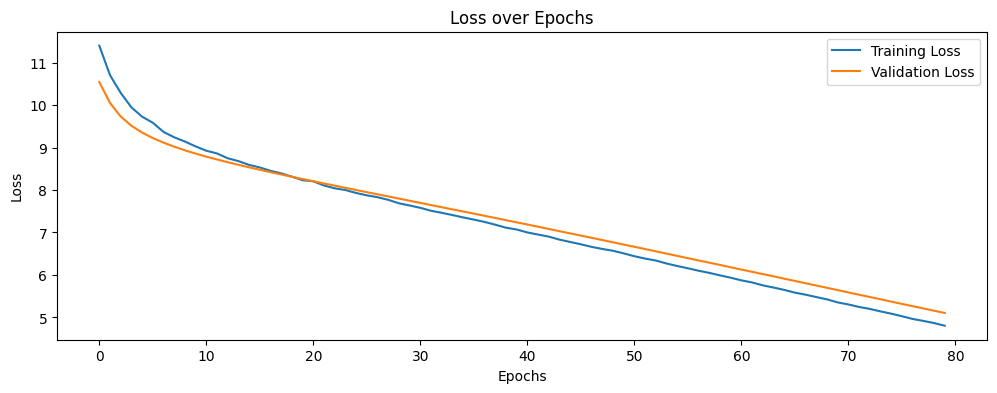

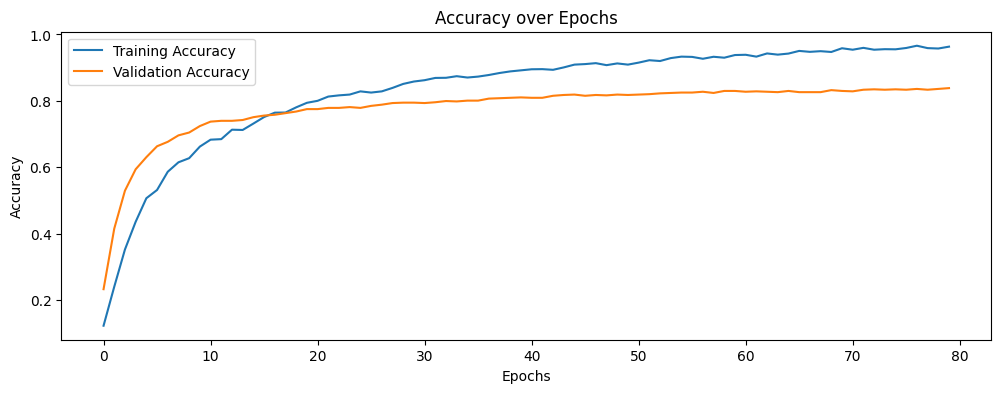

In [28]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [32]:
predictions = classification_model.predict(validation_descriptors)
y_pred = np.argmax(predictions, axis=1)  # Get predicted class indices
y_true = np.argmax(validation_labels, axis=1)
print(f"Predictions shape: {y_pred.shape}")
print(f"True labels shape: {y_true.shape}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
Predictions shape: (822,)
True labels shape: (822,)


In [33]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

       10618       0.88      0.69      0.77        42
      126637       0.96      0.93      0.95        58
      151942       0.70      0.79      0.74        42
      171772       0.95      0.96      0.96        57
      176528       0.82      0.79      0.80        84
      177870       0.87      0.91      0.89        76
      192931       0.83      0.79      0.81        66
       20409       1.00      0.98      0.99        52
       41808       0.65      0.54      0.59        37
       45428       0.78      0.78      0.78        45
       62074       0.86      0.98      0.91        43
       62798       0.76      0.87      0.81       114
       83144       0.95      0.95      0.95        58
       84689       0.69      0.60      0.64        48

    accuracy                           0.84       822
   macro avg       0.84      0.83      0.83       822
weighted avg       0.84      0.84      0.84       822



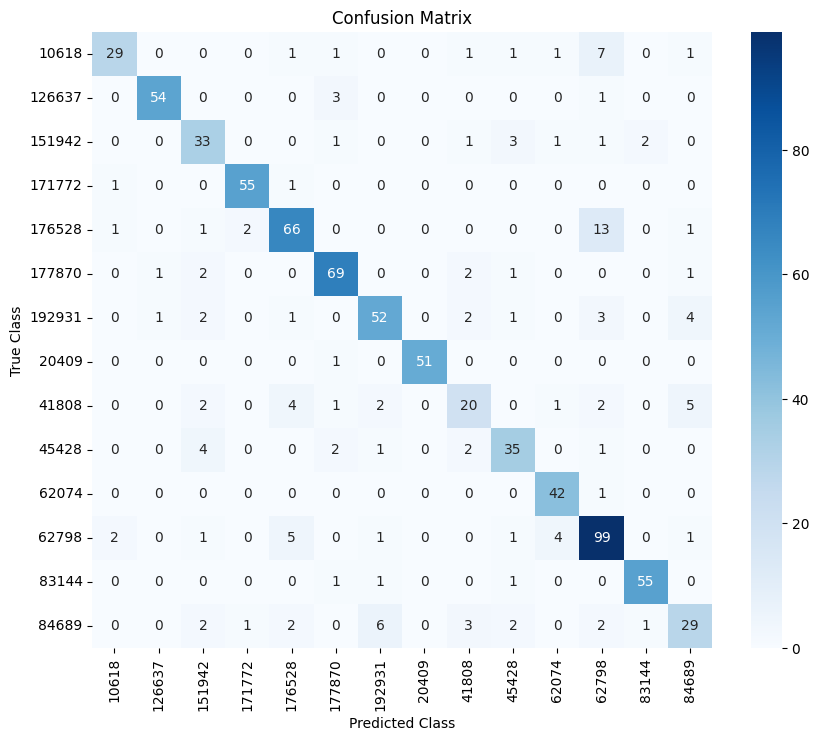

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()
